# Baseline model for batch monitoring example

In [1]:
import requests
import datetime
import pandas as pd

from evidently import ColumnMapping
from evidently.report import Report
from evidently.metrics import ColumnDriftMetric, DatasetDriftMetric, DatasetMissingValuesMetric

from joblib import load, dump
from tqdm import tqdm

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

In [3]:
files = [('green_tripdata_2023-03.parquet', './data'), ('green_tripdata_2023-02.parquet', './data')]

print("Download files:")
for file, path in files:
    url=f"https://d37ci6vzurychx.cloudfront.net/trip-data/{file}"
    resp=requests.get(url, stream=True)
    save_path=f"{path}/{file}"
    with open(save_path, "wb") as handle:
        for data in tqdm(resp.iter_content(),
                        desc=f"{file}",
                        postfix=f"save to {save_path}",
                        total=int(resp.headers["Content-Length"])):
            handle.write(data)

Download files:


green_tripdata_2023-02.parquet: 100%|██████████| 1533740/1533740 [01:01<00:00, 25042.39it/s, save to ./data/green_tripdata_2023-02.parquet]


In [4]:
march_data = pd.read_parquet('data/green_tripdata_2023-03.parquet')

In [5]:
march_data.describe()

,VendorID,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge
count,72044.000000,67507.000000,72044.000000,72044.000000,67507.000000,72044.000000,72044.000000,72044.000000,72044.000000,72044.000000,72044.000000,0.0,72044.000000,72044.000000,67507.000000,67500.000000,67507.000000
mean,1.865443,1.145703,98.437413,137.613556,1.286844,12.449511,17.018203,0.878109,0.576929,2.157651,0.183268,NaN,0.961604,22.292310,1.373680,1.028681,0.714837
std,0.341252,1.225735,60.481870,76.169705,0.923652,641.094653,13.832399,1.297642,0.384129,3.136215,1.139159,NaN,0.185185,15.852047,0.512307,0.166911,1.206435
min,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,-115.000000,-5.000000,-0.500000,-1.100000,0.000000,NaN,-1.000000,-116.000000,1.000000,1.000000,-2.750000
25%,2.000000,1.000000,74.000000,74.000000,1.000000,1.100000,9.300000,0.000000,0.500000,0.000000,0.000000,NaN,1.000000,12.980000,1.000000,1.000000,0.000000
50%,2.000000,1.000000,75.000000,138.000000,1.000000,1.840000,13.500000,0.000000,0.500000,1.600000,0.000000,NaN,1.000000,18.100000,1.000000,1.000000,0.000000
75%,2.000000,1.000000,129.000000,216.000000,1.000000,3.300000,20.000000,1.000000,0.500000,3.360000,0.000000,NaN,1.000000,26.730000,2.000000,1.000000,2.750000
max,2.000000,99.000000,265.000000,265.000000,9.000000,92064.680000,477.000000,12.500000,4.250000,270.270000,36.050000,NaN,1.000000,478.000000,5.000000,2.000000,2.750000


In [6]:
march_data.shape

(72044, 20)

* 1) The shape of the data is (72044, 20)

In [7]:
# create target
march_data["duration_min"] = march_data.lpep_dropoff_datetime - march_data.lpep_pickup_datetime
march_data.duration_min = march_data.duration_min.apply(lambda td : float(td.total_seconds())/60)

In [8]:
# filter out outliers
march_data = march_data[(march_data.duration_min >= 0) & (march_data.duration_min <= 60)]
march_data = march_data[(march_data.passenger_count > 0) & (march_data.passenger_count <= 8)]

<AxesSubplot:>

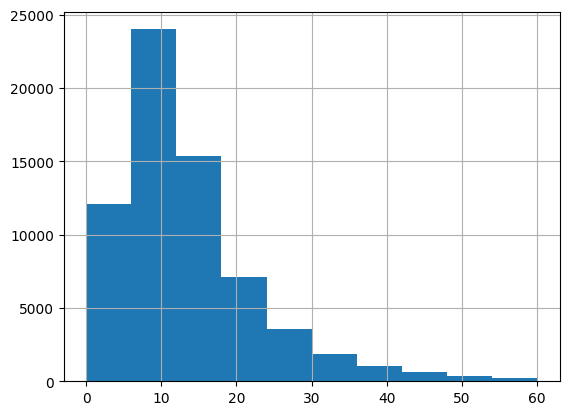

In [9]:
march_data.duration_min.hist()

In [10]:
# data labeling
target = "duration_min"
num_features = ["passenger_count", "trip_distance", "fare_amount", "total_amount"]
cat_features = ["PULocationID", "DOLocationID"]

In [11]:
march_data.shape

(66255, 21)

In [12]:
train_data = march_data[:45000]
val_data = march_data[45000:]

In [13]:
model = LinearRegression()

In [14]:
model.fit(train_data[num_features + cat_features], train_data[target])

LinearRegression()

In [15]:
train_preds = model.predict(train_data[num_features + cat_features])
train_data['prediction'] = train_preds

In [16]:
val_preds = model.predict(val_data[num_features + cat_features])
val_data['prediction'] = val_preds

In [17]:
print(mean_absolute_error(train_data.duration_min, train_data.prediction))
print(mean_absolute_error(val_data.duration_min, val_data.prediction))

3.582455244475127
3.5365734185578366


# Dump model and reference data

In [19]:
with open('models/lin_reg.bin', 'wb') as f_out:
    dump(model, f_out)

In [20]:
val_data.to_parquet('data/reference.parquet')

# Evidently Report

In [21]:
column_mapping = ColumnMapping(
    target=None,
    prediction='prediction',
    numerical_features=num_features,
    categorical_features=cat_features
)

In [22]:
report = Report(metrics=[
    ColumnDriftMetric(column_name='prediction'),
    DatasetDriftMetric(),
    DatasetMissingValuesMetric()
]
)

In [23]:
report.run(reference_data=train_data, current_data=val_data, column_mapping=column_mapping)

In [24]:
report.show(mode='inline')

In [25]:
result = report.as_dict()

In [26]:
result

{'metrics': [{'metric': 'ColumnDriftMetric',
   'result': {'column_name': 'prediction',
    'column_type': 'num',
    'stattest_name': 'Wasserstein distance (normed)',
    'stattest_threshold': 0.1,
    'drift_score': 0.010146046451844193,
    'drift_detected': False}},
  {'metric': 'DatasetDriftMetric',
   'result': {'drift_share': 0.5,
    'number_of_columns': 7,
    'number_of_drifted_columns': 0,
    'share_of_drifted_columns': 0.0,
    'dataset_drift': False}},
  {'metric': 'DatasetMissingValuesMetric',
   'result': {'different_missing_values': {'': 0,
     -inf: 0,
     None: 21256,
     inf: 0},
    'number_of_different_missing_values': 1,
    'different_missing_values_by_column': {'VendorID': {'': 0,
      -inf: 0,
      None: 0,
      inf: 0},
     'lpep_pickup_datetime': {'': 0, -inf: 0, None: 0, inf: 0},
     'lpep_dropoff_datetime': {'': 0, -inf: 0, None: 0, inf: 0},
     'store_and_fwd_flag': {'': 0, -inf: 0, None: 0, inf: 0},
     'RatecodeID': {'': 0, -inf: 0, None: 0, i

In [27]:
#prediction drift
result['metrics'][0]['result']['drift_score']

0.010146046451844193

In [28]:
#number of drifted columns
result['metrics'][1]['result']['number_of_drifted_columns']

0

In [31]:
#share of missing values
result['metrics'][2]['result']['share_of_missing_values']

0.04545668398879408